In [1]:
# This cell has a bit of initial setup. You can click the triangle to the left to expand it.
# Click the "Run" button immediately above the notebook in order to execute the contents of any cell
# WARNING: Each cell in the notebook relies upon results generated by previous cells
#   The most common problem beginners have is to execute a cell before all its predecessors
#   If you do this, you can restart the kernel (see the "Kernel" menu above) and start over
%matplotlib inline
import matplotlib.pyplot as plt

# The first step is to be able to bring things in from different directories
import sys 
import os

sys.path.insert(0, os.path.abspath('../lib'))

#from util import log_progress

import numpy as np
import HARK 
from time import clock
from copy import deepcopy
mystr = lambda number : "{:.4f}".format(number)
from HARK.utilities import plotFuncs

In [2]:
# Define a parameter dictionary with baseline parameter values

# Set the baseline parameter values 
PermGroFac = 1.02
Rfree      = 1
DiscFac    = 0.96
CRRA       = 2.00
UnempPrb   = 0.005
IncUnemp   = 0.0
PermShkStd = 0.1
TranShkStd = 0.1
# Import default parameter values
import HARK.ConsumptionSaving.ConsumerParameters as Params 

# Make a dictionary containing all parameters needed to solve the model
base_params = Params.init_idiosyncratic_shocks

# Set the parameters for the baseline results in the paper
# using the variable values defined in the cell above
base_params['PermGroFac'] = [PermGroFac]   # Permanent income growth factor
base_params['Rfree']      = Rfree          # Interest factor on assets
base_params['DiscFac']    = DiscFac        # Time Preference Factor
base_params['CRRA']       = CRRA           # Coefficient of relative risk aversion
base_params['UnempPrb']   = UnempPrb       # Probability of unemployment (e.g. Probability of Zero Income in the paper)
base_params['IncUnemp']   = IncUnemp       # Induces natural borrowing constraint
base_params['PermShkStd'] = [PermShkStd]   # Standard deviation of log permanent income shocks
base_params['TranShkStd'] = [TranShkStd]   # Standard deviation of log transitory income shocks

# Some technical settings that are not interesting for our purposes
base_params['LivPrb']       = [1.0]   # 100 percent probability of living to next period
base_params['CubicBool']    = True    # Use cubic spline interpolation
base_params['T_cycle']      = 1       # No 'seasonal' cycles
base_params['BoroCnstArt']  = None    # No artificial borrowing constraint

In [3]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
baseEx_inf = IndShockConsumerType(cycles=0,**base_params)

baseEx_inf.solve()
baseEx_inf.unpackcFunc()

The given type violates the finite human wealth condition; the finite human wealth factor value 1.02000 


In [4]:
# Define a function to calculate expected consumption 
def exp_consumption(a):
    '''
    Taking end-of-period assets as input, return expectation of next period's consumption
    Inputs:
       a: end-of-period assets
    Returns:
       expconsump: next period's expected consumption
    '''
    GrowFactp1 = baseEx_inf.PermGroFac[0]* baseEx_inf.PermShkDstn[0][1]
    Rnrmtp1 = baseEx_inf.Rfree / GrowFactp1
    # end-of-period assets plus normalized returns
    btp1 = Rnrmtp1*a
    # expand dims of btp1 and use broadcasted sum of a column and a row vector
    # to obtain a matrix of possible beginning-of-period assets next period
    mtp1 = np.expand_dims(btp1, axis=1) + baseEx_inf.TranShkDstn[0][1]
    part_expconsumption = GrowFactp1*baseEx_inf.cFunc[0](mtp1).T
    # finish expectation over permanent income shocks by right multiplying with
    # the weights
    part_expconsumption = np.dot(part_expconsumption, baseEx_inf.PermShkDstn[0][0])
    # finish expectation over transitory income shocks by right multiplying with
    # weights
    expconsumption = np.dot(part_expconsumption, baseEx_inf.TranShkDstn[0][0])
    # return expected consumption
    return expconsumption

In [5]:
# Calculate the expected consumption growth factor
m1 = np.linspace(1,baseEx_inf.solution[0].mNrmSS,50) # m1 defines the plot range on the left of target m value (e.g. m <= target m)
c_m1 = baseEx_inf.cFunc[0](m1)
a1 = m1-c_m1
exp_consumption_l1 = [exp_consumption(i) for i in a1]

# growth1 defines the values of expected consumption growth factor when m is less than target m
growth1 = np.array(exp_consumption_l1)/c_m1

# m2 defines the plot range on the right of target m value (e.g. m >= target m)
m2 = np.linspace(baseEx_inf.solution[0].mNrmSS,1.9,50)

c_m2 = baseEx_inf.cFunc[0](m2)
a2 = m2-c_m2
exp_consumption_l2 = [exp_consumption(i) for i in a2]

# growth 2 defines the values of expected consumption growth factor when m is bigger than target m
growth2 = np.array(exp_consumption_l2)/c_m2

(0.98, 1.08)

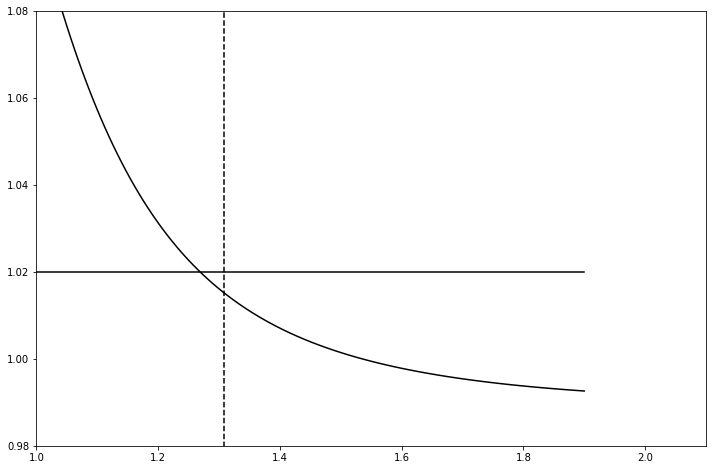

In [6]:
# Plot consumption growth as a function of market resources
# Calculate Absolute Patience Factor Phi = lower bound of consumption growth factor
AbsPatientFac = (baseEx_inf.Rfree*baseEx_inf.DiscFac)**(1.0/baseEx_inf.CRRA)

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)
# Plot the Absolute Patience Factor line
ax.plot([0,1.9],[AbsPatientFac,AbsPatientFac],color="black")

# Plot the Permanent Income Growth Factor line
ax.plot([0,1.9],[baseEx_inf.PermGroFac[0],baseEx_inf.PermGroFac[0]],color="black")

# Plot the expected consumption growth factor on the left side of target m
ax.plot(m1,growth1,color="black")

# Plot the expected consumption growth factor on the right side of target m
ax.plot(m2,growth2,color="black")

# Plot the arrows
#arrowplot(ax, m1,growth1)
#arrowplot(ax, m2,growth2, direc='pos')

# Plot the target m
ax.plot([baseEx_inf.solution[0].mNrmSS,baseEx_inf.solution[0].mNrmSS],[0,1.4],color="black",linestyle="--")
ax.set_xlim(1,2.10)
ax.set_ylim(0.98,1.08)
#ax.text(1,1.082,"Growth Rate",fontsize = 26,fontweight='bold')
#ax.text(2.105,0.975,"$m_{t}$",fontsize = 26,fontweight='bold')
#if iflatexExists:
#    ax.text(1.91,1.01,"$\mathbb{E}_{t}[\mathbf{c}_{t+1}/\mathbf{c}_{t}]$",fontsize = 22,fontweight='bold')
#else:
#    ax.text(1.91,1.01,"$\mathsf{E}_{t}[c_{t+1}/c_{t}]$",fontsize = 22,fontweight='bold')
#ax.text(baseEx_inf.solution[0].mNrmSS-0.02,0.974, r'$\check{m}$', fontsize = 26,fontweight='bold')
#ax.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
##if iflatexExists:
#    ax.text(1.91,0.998,r'$\pmb{\text{\TH}} = (\mathrm{\mathsf{R}}\beta)^{1/\rho}$',fontsize = 22,fontweight='bold')
#else:
#    ax.text(1.91,0.998,r'$\Phi = (\mathrm{\mathsf{R}}\beta)^{1/\rho}$',fontsize = 22,fontweight='bold')#

#ax.text(1.91,1.03, r'$\Gamma$',fontsize = 22,fontweight='bold')
#if Generator:
#    fig.savefig(os.path.join(Figures_HARK_dir, 'cGroTargetFig.png'))
#    fig.savefig(os.path.join(Figures_HARK_dir, 'cGroTargetFig.jpg'))
#    fig.savefig(os.path.join(Figures_HARK_dir, 'cGroTargetFig.pdf'))
#    fig.savefig(os.path.join(Figures_HARK_dir, 'cGroTargetFig.svg'))
#if not in_ipynb():
#    plt.show(block=False) 
#    plt.pause(1)
#else:
#    plt.show(block=True) # Change to False if you want to run uninterrupted

In [7]:
# Set the baseline parameter values 
PermGroFac = 1.005
Rfree      = 1
DiscFac    = 0.96
CRRA       = 2.00
UnempPrb   = 0.005
IncUnemp   = 0.0
PermShkStd = 0.1
TranShkStd = 0.1
# Import default parameter values
import HARK.ConsumptionSaving.ConsumerParameters as Params 

# Make a dictionary containing all parameters needed to solve the model
params1 = Params.init_idiosyncratic_shocks

# Set the parameters for the baseline results in the paper
# using the variable values defined in the cell above
params1['PermGroFac'] = [PermGroFac]   # Permanent income growth factor
params1['Rfree']      = Rfree          # Interest factor on assets
params1['DiscFac']    = DiscFac        # Time Preference Factor
params1['CRRA']       = CRRA           # Coefficient of relative risk aversion
params1['UnempPrb']   = UnempPrb       # Probability of unemployment (e.g. Probability of Zero Income in the paper)
params1['IncUnemp']   = IncUnemp       # Induces natural borrowing constraint
params1['PermShkStd'] = [PermShkStd]   # Standard deviation of log permanent income shocks
params1['TranShkStd'] = [TranShkStd]   # Standard deviation of log transitory income shocks

# Some technical settings that are not interesting for our purposes
params1['LivPrb']       = [1.0]   # 100 percent probability of living to next period
params1['CubicBool']    = True    # Use cubic spline interpolation
params1['T_cycle']      = 1       # No 'seasonal' cycles
params1['BoroCnstArt']  = None    # No artificial borrowing constraint

In [8]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
model1 = IndShockConsumerType(cycles=0,**params1)

model1.solve()
model1.unpackcFunc()

The given type violates the finite human wealth condition; the finite human wealth factor value 1.00500 


In [9]:
# Calculate the expected consumption growth factor
m11 = np.linspace(1,model1.solution[0].mNrmSS,50) # m1 defines the plot range on the left of target m value (e.g. m <= target m)
c_m11 = model1.cFunc[0](m11)
a11 = m11-c_m11
exp_consumption_l11 = [exp_consumption(i) for i in a11]

# growth1 defines the values of expected consumption growth factor when m is less than target m
growth11 = np.array(exp_consumption_l11)/c_m11

# m2 defines the plot range on the right of target m value (e.g. m >= target m)
m22 = np.linspace(model1.solution[0].mNrmSS,1.9,50)

c_m22 = model1.cFunc[0](m22)
a22 = m22-c_m22
exp_consumption_l22 = [exp_consumption(i) for i in a22]

# growth 2 defines the values of expected consumption growth factor when m is bigger than target m
growth22 = np.array(exp_consumption_l22)/c_m22

(0.98, 1.08)

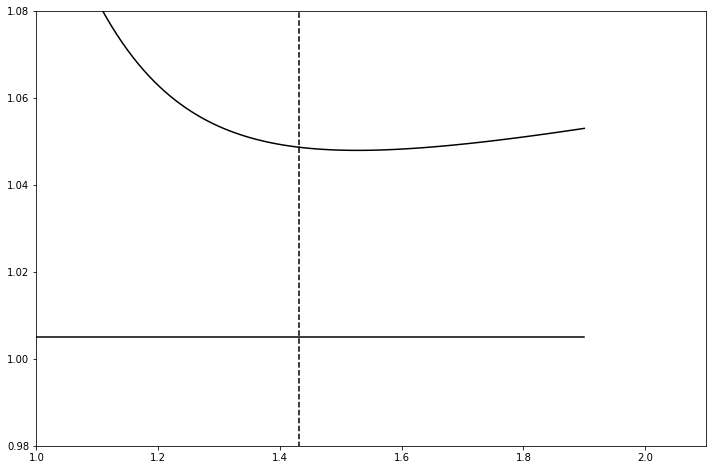

In [10]:
# Plot consumption growth as a function of market resources
# Calculate Absolute Patience Factor Phi = lower bound of consumption growth factor
AbsPatientFac = (model1.Rfree*model1.DiscFac)**(1.0/model1.CRRA)

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)
# Plot the Absolute Patience Factor line
ax.plot([0,1.9],[AbsPatientFac,AbsPatientFac],color="black")

# Plot the Permanent Income Growth Factor line
ax.plot([0,1.9],[model1.PermGroFac[0],model1.PermGroFac[0]],color="black")

# Plot the expected consumption growth factor on the left side of target m
ax.plot(m11,growth11,color="black")

# Plot the expected consumption growth factor on the right side of target m
ax.plot(m22,growth22,color="black")

# Plot the arrows
#arrowplot(ax, m1,growth1)
#arrowplot(ax, m2,growth2, direc='pos')

# Plot the target m
ax.plot([model1.solution[0].mNrmSS,model1.solution[0].mNrmSS],[0,1.4],color="black",linestyle="--")
ax.set_xlim(1,2.10)
ax.set_ylim(0.98,1.08)